In [1]:
# interpolate [co2] from 47 model levels to 20 OCO2 levels

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

from matplotlib import rcParams
rcParams["savefig.dpi"] = 200
rcParams["font.size"] = 12

import warnings
warnings.filterwarnings('ignore')

In [3]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import re

In [4]:
# month of the simulation
month  = 3     # 1,2,3
case_name = 'CO2-2018'

In [5]:
if(month >= 10):
    model_file = '2d_ts_satellite.2018' + str(month) + '.nc'
    satellite_file = '2d_OCO2_extract_2018' + str(month) + '.nc'
else:
    model_file = '2d_ts_satellite.20180' + str(month) + '.nc'
    satellite_file = '2d_OCO2_extract_20180' + str(month) + '.nc'

In [6]:
# Name and path of inputs and outputs
input_directory = '/geos/u73/msadiq/GEOS-Chem/rundirs/ensemble_runs/' + case_name + '/nd51/'
input_file = input_directory + model_file
# corresponding satellite data
satellite_directory = '/geos/u73/msadiq/satellite/oco-2/'

output_file = input_directory + 'interpolated_' + model_file
output_directory = input_directory

In [7]:
# model input
ds_model          = xr.open_dataset(input_file)

levels_model      = ds_model['levels']
surf_press_mod    = ds_model['PEDGE_S_PSURF']
profile_press_mod = surf_press_mod * levels_model # pressure at different levels
record            = ds_model['record'].values

In [8]:
# satellite input
ds_satellite = xr.open_dataset(satellite_directory + satellite_file)
levels_sat = ds_satellite['levels']
surf_press_sat = ds_satellite['psurf']       # not really needed
profile_press_sat = ds_satellite['pressure'] # pressure profile of different levels
print(profile_press_sat[9442].values)
# multi_pressure = surf_pressure * levels_sat
# multi_pressure[47007,:].values            # same as pressure profile

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


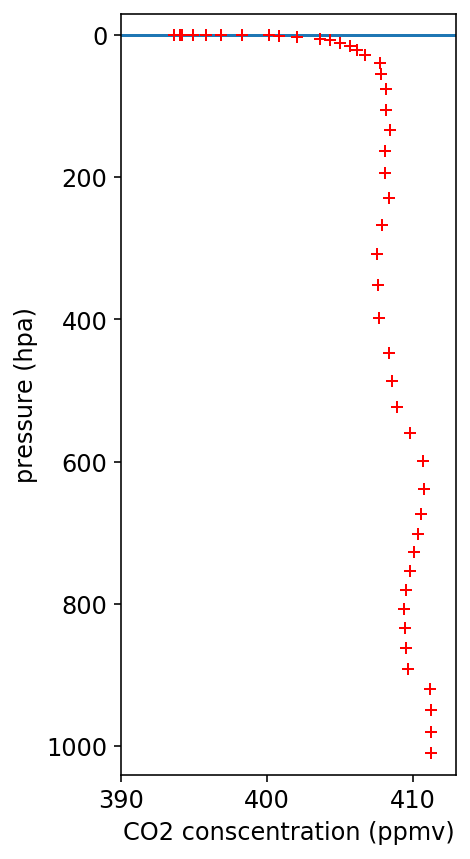

In [9]:
# pick one location where we have data from OCO2 
# and show difference in levels
irecord = 9442
y_press_mod = profile_press_mod[irecord,:].values
y_press_sat = profile_press_sat[irecord].values
x_co2       = ds_model['SpeciesConc_CO2'][47007,:] # 47 levels

fig, ax = plt.subplots(figsize=[3,7])

ax.plot(x_co2*1e-3, y_press_mod, 'r+') # co2 unit is still ppbv here
ax.set_ylim(1040,-30)  # reverse y axis
ax.set_xlim(390,413)
ax.set_xlabel('CO2 conscentration (ppmv)')
ax.set_ylabel('pressure (hpa)')
ax.eventplot(y_press_sat, lineoffsets=400, # add horizonal lines of satellite pressure levels
                    linelengths=100, orientation = 'vertical')

plt.show()

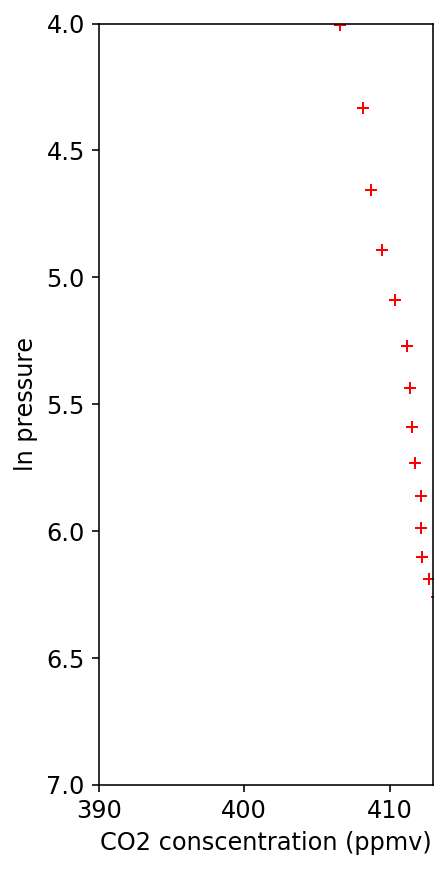

In [10]:
# pick one location where we have data from OCO2
# show in ln pressure coordinate
# linear interpolation using ln(pressure)
# show results of interpolation
y_press_mod = np.log(profile_press_mod[irecord,:].values)
y_press_sat = np.log(profile_press_sat[irecord].values)
x_co2       = ds_model['SpeciesConc_CO2'][irecord,:]

interpolated_co2 = np.interp(x = y_press_sat, xp = np.flip(y_press_mod), fp = np.flip(x_co2)) # linear inte

fig, ax = plt.subplots(figsize=[3,7])

ax.plot(x_co2*1e-3, y_press_mod, 'r+')
ax.plot(interpolated_co2*1e-3, y_press_sat, 'b^')
ax.set_ylim(7,4)
ax.set_xlim(390,413)
ax.set_xlabel('CO2 conscentration (ppmv)')
ax.set_ylabel('ln pressure')
ax.eventplot(y_press_sat, lineoffsets=400, # add horizonal lines of satellite pressure levels
                    linelengths=100, orientation = 'vertical')

plt.show()

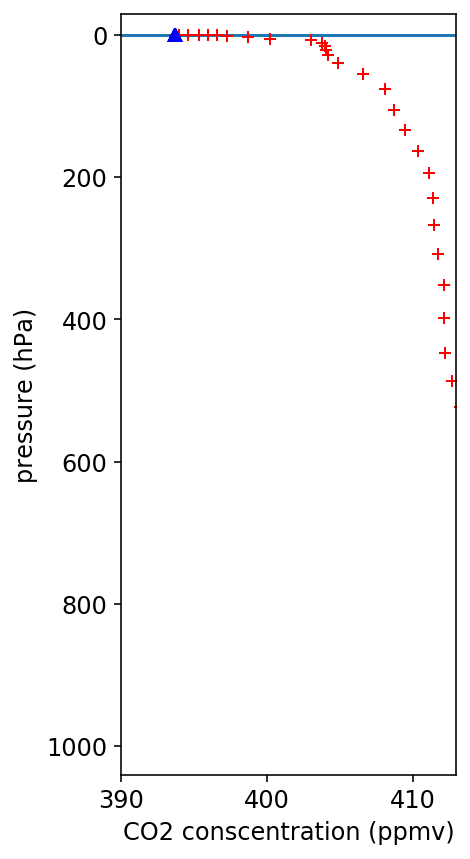

In [11]:
y_press_mod = profile_press_mod[irecord,:].values
y_press_sat = profile_press_sat[irecord].values
x_co2       = ds_model['SpeciesConc_CO2'][irecord,:]

fig, ax = plt.subplots(figsize=[3,7])

ax.plot(x_co2*1e-3, y_press_mod, 'r+')
ax.plot(interpolated_co2*1e-3, y_press_sat, 'b^')
ax.set_ylim(1040,-30)
ax.set_xlim(390,413)
ax.set_xlabel('CO2 conscentration (ppmv)')
ax.set_ylabel('pressure (hPa)')
ax.eventplot(y_press_sat, lineoffsets=400, # add horizonal lines of satellite pressure levels
                    linelengths=100, orientation = 'vertical')

plt.show()
fig.savefig(output_directory + 'interpolation.png', bbox_inches='tight')

In [12]:
# new dataset to store interpolated co2 from model
interpolated = ds_satellite['pressure'].to_dataset()
interpolated

<xarray.Dataset>
Dimensions:   (levels: 20, record: 406224)
Coordinates:
  * record    (record) int64 0 1 2 3 4 5 ... 406219 406220 406221 406222 406223
  * levels    (levels) float32 1e-04 0.05263158 0.10526316 ... 0.94736844 1.0
Data variables:
    pressure  (record, levels) float32 ...

In [13]:
varnames = list(ds_model.keys())  # Get a list of variable names. The expression is a bit cumbersome. Just copy and paste it for now.
nvar = len(varnames)  # how many elements in the list?
needed_vars = np.append(varnames[0], varnames[7:29])
needed_vars

array(['SpeciesConc_CO2'], dtype='<U32')

In [14]:
# temporary 2d dataarray to save interpolated data
tmp = xr.DataArray(data = 0,
                   dims=('record', 'levels'),
                   coords=[record, ds_satellite.coords['levels']])
tmp = tmp.astype(dtype = 'float32')
tmp

<xarray.DataArray (record: 406224, levels: 20)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)
Coordinates:
  * record   (record) int64 0 1 2 3 4 5 ... 406219 406220 406221 406222 406223
  * levels   (levels) float32 1e-04 0.05263158 0.10526316 ... 0.94736844 1.0

In [15]:
for ivar in needed_vars:
    interpolated[ivar] = tmp.copy()
interpolated

<xarray.Dataset>
Dimensions:          (levels: 20, record: 406224)
Coordinates:
  * record           (record) int64 0 1 2 3 4 ... 406220 406221 406222 406223
  * levels           (levels) float32 1e-04 0.05263158 ... 0.94736844 1.0
Data variables:
    pressure         (record, levels) float32 ...
    SpeciesConc_CO2  (record, levels) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0

In [16]:
# interpolation
for irecord in record:
    if profile_press_sat[irecord][19] != 0.:   # if measurement is non-zero, i.e. exists
        for ivar in needed_vars:
            before         = ds_model[ivar] # get co2 before interpolation
            x_co2          = before[irecord,:].values # a co2 profile
            pres_before    = np.log(profile_press_mod[irecord].values) # log space
            pres_after     = np.log(profile_press_sat[irecord])
            # linear interpolation            
            interpolated[ivar][irecord,:] = np.interp(x  = pres_after, 
                                                      xp = np.flip(pres_before), # increasing order
                                                      fp = np.flip(x_co2)) 
        print(irecord)

1640
1843
1947
2090
2174
2175
2234
2318
2358
2482
2501
2541
2759
2769
2780
2799
2903
2913
2924
2942
2943
3012
3047
3057
3067
3068
3086
3155
3181
3200
3211
3230
3299
3334
3344
3374
3403
3443
3478
3488
3508
3517
3518
3547
3651
3652
3661
3691
3730
3731
3795
3805
3835
3874
3919
3939
3949
3979
4018
4038
4053
4063
4083
4093
4113
4122
4142
4153
4162
4172
4182
4197
4207
4227
4236
4237
4257
4266
4286
4297
4306
4316
4325
4331
4341
4380
4390
4401
4410
4430
4440
4441
4449
4450
4459
4469
4475
4484
4485
4494
4495
4534
4545
4554
4574
4584
4593
4603
4613
4628
4638
4668
4678
4689
4698
4717
4737
4747
4757
4772
4782
4812
4822
4841
4861
4872
4891
4916
4926
4956
4965
4966
4985
5005
5035
5044
5060
5070
5099
5109
5120
5129
5149
5188
5204
5213
5214
5243
5253
5264
5293
5332
5347
5348
5357
5387
5408
5437
5476
5491
5501
5531
5541
5620
5635
5645
5675
5685
5764
5779
5789
5818
5819
5828
5868
5907
5923
5933
5962
5972
6051
6067
6077
6116
6195
6210
6211
6220
6240
6260
6299
6300
6354
6364
6384
6404
6463
6498
6508
6548


47706
47726
47737
47756
47757
47765
47805
47830
47850
47870
47880
47909
47920
47949
47964
48013
48014
48024
48044
48053
48073
48157
48168
48188
48197
48217
48236
48281
48340
48341
48351
48405
48416
48425
48464
48549
48568
48569
48588
48608
48628
48703
48704
48712
48752
48783
48811
48821
48847
48856
48876
48887
48896
48926
48927
48955
49000
49019
49020
49031
49050
49051
49070
49079
49163
49194
49214
49222
49358
49594
49613
49737
49901
50128
54182
54325
54326
54405
54434
54577
54578
54603
54721
54736
54737
54746
54747
54835
54836
54865
54890
54900
54979
55034
55143
55162
55286
55430
55450
55465
55515
55574
55594
55658
55753
55773
55774
55782
55802
55822
55917
55926
55936
55946
55966
56025
56050
56061
56070
56080
56090
56109
56129
56149
56194
56205
56214
56223
56224
56233
56234
56253
56273
56293
56312
56338
56348
56357
56358
56367
56377
56397
56417
56446
56456
56472
56481
56482
56492
56501
56521
56541
56561
56590
56600
56605
56615
56625
56636
56645
56655
56685
56704
56715
56734
56744
5674

98974
98984
98994
99034
99053
99118
99138
99177
99197
99253
99262
99272
99282
99321
99341
99351
99397
99406
99416
99425
99426
99445
99465
99485
99495
99549
99550
99559
99569
99580
99589
99629
99638
99639
99693
99703
99713
99733
99743
99772
99782
99837
99847
99857
99867
99868
99877
99887
99916
99926
99981
99991
100001
100011
100020
100031
100051
100060
100070
100125
100134
100135
100144
100145
100155
100164
100175
100184
100195
100278
100288
100299
100319
100328
100339
100422
100432
100462
100463
100471
100472
100556
100566
100595
100596
100606
100710
100739
100759
100834
100835
100853
100863
100883
100894
100914
100942
100978
101007
101038
101057
101131
101170
101190
101201
101210
101266
101334
101345
101353
101354
101477
101478
101497
101572
101593
101776
101804
101869
101880
101920
102155
102156
102167
102168
102299
102311
102442
102443
102455
107204
107427
107452
107482
107571
107705
107848
107849
107913
107992
108017
108136
108156
108211
108220
108260
108280
108299
108315
108364
10

148630
148640
148660
148680
148690
148691
148700
148730
148739
148749
148764
148774
148784
148824
148834
148843
148844
148874
148883
148893
148903
148908
148918
148928
148967
148968
148978
148987
149007
149018
149027
149037
149046
149052
149062
149072
149101
149111
149122
149131
149161
149162
149171
149181
149190
149196
149206
149215
149216
149245
149255
149266
149275
149305
149314
149324
149334
149340
149349
149350
149359
149389
149399
149419
149439
149449
149458
149468
149483
149484
149493
149503
149533
149543
149553
149602
149627
149637
149647
149667
149677
149687
149697
149746
149771
149781
149791
149820
149821
149830
149841
149909
149915
149925
149935
149964
149974
150053
150059
150069
150078
150079
150108
150118
150168
150197
150203
150212
150213
150222
150252
150262
150341
150346
150356
150366
150396
150406
150425
150426
150445
150485
150490
150500
150521
150540
150549
150550
150569
150589
150628
150629
150634
150644
150654
150664
150683
150684
150693
150713
150733
150772
150778

191297
191307
191316
191317
191356
191421
191440
191441
191451
191460
191471
191500
191510
191564
191584
191595
191604
191615
191643
191644
191653
191654
191708
191728
191739
191748
191758
191759
191778
191787
191797
191852
191872
191882
191883
191902
191922
191931
191941
191996
192015
192016
192026
192046
192066
192075
192085
192131
192139
192140
192159
192179
192190
192210
192228
192229
192238
192274
192283
192303
192314
192323
192334
192353
192372
192418
192447
192466
192467
192478
192497
192516
192526
192562
192571
192590
192591
192610
192630
192734
192754
192878
192898
193022
193033
193042
193081
193165
193176
193177
193185
193196
193225
193368
193512
194763
198446
198589
198714
198733
198857
198981
199026
199170
199209
199269
199308
199344
199353
199412
199452
199595
199596
199601
199621
199640
199720
199729
199739
199765
199784
199873
199908
199928
200017
200027
200072
200131
200161
200196
200207
200216
200225
200226
200275
200295
200304
200305
200314
200330
200350
200351
200360

233355
233499
233642
233785
237879
238023
238097
238310
238384
238453
238454
238498
238528
238597
238682
238741
238806
238816
238845
238885
238904
238949
239029
239048
239054
239073
239192
239217
239276
239296
239336
239361
239372
239420
239460
239505
239516
239535
239564
239604
239613
239614
239639
239648
239649
239659
239660
239708
239747
239748
239757
239782
239783
239792
239803
239812
239822
239832
239852
239891
239901
239911
239926
239956
239966
239976
239986
240035
240045
240070
240100
240110
240119
240120
240130
240170
240179
240189
240204
240214
240224
240244
240254
240263
240274
240314
240323
240333
240348
240358
240368
240397
240407
240418
240447
240457
240458
240466
240467
240476
240477
240486
240492
240502
240511
240512
240551
240562
240571
240591
240601
240610
240620
240630
240635
240636
240645
240655
240685
240705
240706
240734
240745
240754
240764
240774
240779
240789
240819
240829
240849
240878
240889
240898
240908
240918
240923
240933
240963
240973
240982
240983
240993

278749
278769
278788
278804
278814
278873
278893
278913
278932
278957
278958
279017
279037
279056
279066
279076
279091
279101
279141
279161
279200
279210
279220
279235
279245
279265
279285
279295
279324
279335
279344
279364
279389
279428
279439
279479
279498
279523
279533
279572
279583
279592
279622
279623
279641
279642
279667
279676
279677
279716
279727
279736
279766
279785
279795
279810
279811
279820
279860
279871
279880
279899
279910
279929
279939
279964
280004
280014
280023
280024
280043
280054
280063
280073
280108
280148
280158
280167
280187
280207
280217
280242
280252
280291
280311
280331
280351
280361
280370
280386
280396
280435
280455
280475
280504
280505
280530
280539
280540
280579
280619
280673
280674
280683
280723
280743
280762
280763
280792
280817
280827
280867
280961
280971
281001
281011
281030
281105
281115
281154
281174
281249
281259
281298
281318
281367
281368
281393
281442
281462
281511
281521
281536
281586
281645
281655
281665
281680
281730
281749
281750
281780
281789

321118
321127
321143
321242
321261
321262
321271
321287
321306
321386
321415
321510
321559
321574
321594
321644
321653
321654
321664
321703
321718
321738
321788
321797
321862
321882
321901
321902
321912
321932
321941
321961
321996
322006
322025
322026
322045
322076
322085
322105
322150
322160
322169
322189
322200
322220
322229
322249
322268
322293
322294
322304
322313
322333
322363
322372
322373
322392
322412
322422
322437
322448
322457
322477
322487
322507
322516
322536
322556
322565
322566
322581
322592
322601
322631
322660
322700
322709
322744
322745
322764
322775
322795
322804
322815
322843
322844
322853
322879
322888
322908
322919
322928
322939
322948
322987
322997
323012
323032
323052
323072
323131
323141
323156
323167
323176
323196
323206
323207
323216
323275
323284
323290
323300
323339
323340
323350
323419
323428
323443
323444
323454
323483
323494
323577
323578
323587
323598
323627
323647
323657
323686
323706
323770
323771
323791
323801
323830
323875
323894
323895
323914
323925

362104
362113
362152
362162
362168
362188
362197
362217
362228
362237
362248
362257
362296
362332
362341
362361
362372
362380
362381
362400
362440
362449
362476
362485
362505
362524
362544
362584
362593
362620
362648
362668
362688
362727
362728
362763
362792
362812
362832
362862
362907
362936
362955
362956
362975
362995
363006
363051
363079
363080
363099
363119
363195
363243
363263
363302
363338
363387
363446
363491
363570
363857
363868
363869
363992
364001
364012
364136
364144
364156
364189
364228
364229
364299
364300
364332
364372
365108
369267
369490
369634
369653
369698
369777
369842
369921
369986
370005
370045
370129
370149
370273
370372
370417
370496
370516
370561
370620
370640
370660
370705
370724
370764
370784
370803
370848
370849
370868
370888
370908
370927
370928
370947
370992
371012
371032
371052
371062
371071
371136
371176
371215
371280
371300
371319
371339
371359
371424
371443
371444
371463
371494
371503
371587
371598
371607
371627
371638
371647
371731
371751
371771
371781

In [17]:
# variables need not to be interpolated
noneed_interp = ['lat', 'lon', 'date']
for ivar in noneed_interp:
    interpolated[ivar] = ds_model[ivar].copy()

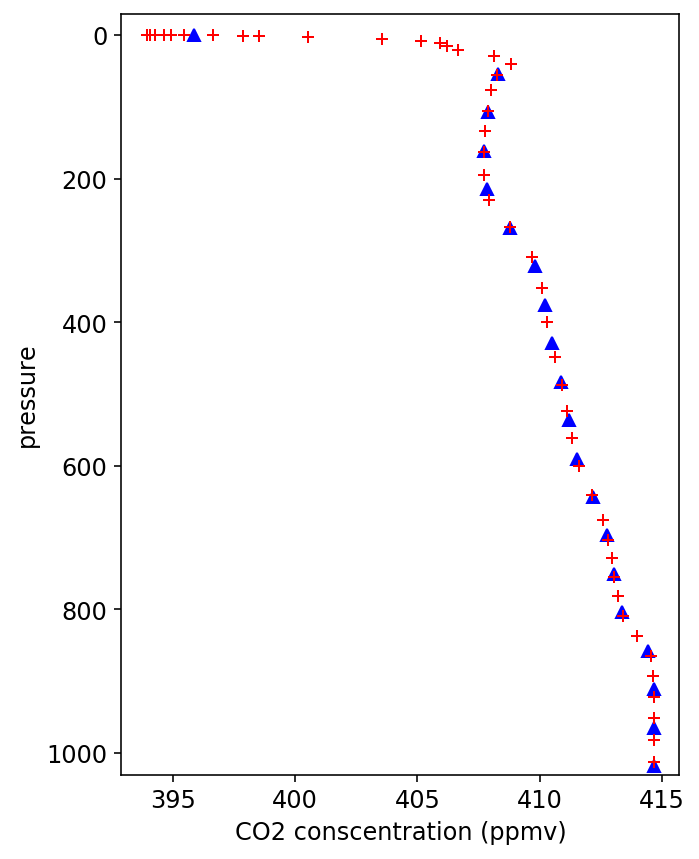

In [20]:
# after interpolation
irecord = 336231
varname = 'SpeciesConc_CO2'
x_co2_after    = interpolated[varname][irecord,:]
y_press_after  = interpolated['pressure'][irecord,:]

x_co2_before   = ds_model[varname][irecord,:]
y_press_before = profile_press_mod[irecord]

fig, ax = plt.subplots(figsize=[5,7])

ax.plot(x_co2_after*1e-3, y_press_after, 'b^')
ax.plot(x_co2_before*1e-3, y_press_before, 'r+')
ax.set_ylim(1030,-30)
#ax.set_xlim(390,413)
ax.set_xlabel('CO2 conscentration (ppmv)')
ax.set_ylabel('pressure')

plt.show()

In [21]:
interpolated.attrs['comment'] = 'interpolated from 47 level model outputs'
interpolated.to_netcdf(output_file)

In [22]:
interpolated

<xarray.Dataset>
Dimensions:          (levels: 20, record: 406224)
Coordinates:
  * record           (record) int64 0 1 2 3 4 ... 406220 406221 406222 406223
  * levels           (levels) float32 1e-04 0.05263158 ... 0.94736844 1.0
Data variables:
    pressure         (record, levels) float32 ...
    SpeciesConc_CO2  (record, levels) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    lat              (record) float64 -89.5 -89.5 -89.5 -89.5 ... 89.5 89.5 89.5
    lon              (record) float64 -180.0 -177.5 -175.0 ... 172.5 175.0 177.5
    date             (record) datetime64[ns] 2018-03-01 ... 2018-03-31
Attributes:
    comment:  interpolated from 47 level model outputs